 "lift" и "gain" метрики были взяты с сайта: https://neptune.ai/blog/evaluation-metrics-binary-classification

In [168]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
import gc
import warnings


pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

## Экспериментальный датасет 1

In [169]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X,y) 

model = LogisticRegression(C=10000)
model.fit(X_train, y_train)

data = pd.DataFrame(columns=['category', 'id', 'fact_target', 'predict', 'is_test'])
data['category'] = list(map(lambda x: f'2020-{x if x>9 else "0"+str(x)}', np.random.choice([1,2],len(X))))
data['id']= range(len(X))
data['fact_target'] = np.concatenate([y_train, y_test])
data['predict'] = np.concatenate([model.predict_proba(X_train)[:,1],  model.predict_proba(X_test)[:,1]])
data['is_test'] = [0 if i<427 else 1 for i in range(len(X))]

## Эксперимантальный датасет 2

In [170]:
# %%time
# n_samples = 50000

# data = pd.DataFrame(columns=['category', 'id', 'fact_target', 'predict', 'is_test'])

# data['category'] = list(map(lambda x: f'2020-{x if x>9 else "0"+str(x)}-{x}', np.random.choice([1,2,3,4,5,6,7,8,9,10,11,12],n_samples)))
# data['id']=range(n_samples)
# data['fact_target'] = np.random.binomial(1, 0.2, n_samples)
# data['predict'] = np.random.normal(0.2, 0.4, n_samples).clip(0,1)
# data['is_test'] = np.random.binomial(1, 0.15, n_samples)

In [171]:
data.describe(include='all')

category          id  fact_target       predict     is_test
count       569  569.000000   569.000000  5.690000e+02  569.000000
unique        2         NaN          NaN           NaN         NaN
top     2020-02         NaN          NaN           NaN         NaN
freq        285         NaN          NaN           NaN         NaN
mean        NaN  284.000000     0.627417  6.301213e-01    0.249561
std         NaN  164.400426     0.483918  4.505348e-01    0.433140
min         NaN    0.000000     0.000000  5.076829e-64    0.000000
25%         NaN  142.000000     0.000000  2.960844e-03    0.000000
50%         NaN  284.000000     1.000000  9.601273e-01    0.000000
75%         NaN  426.000000     1.000000  9.971490e-01    0.000000
max         NaN  568.000000     1.000000  9.999972e-01    1.000000

In [195]:
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_score,\
                            recall_score, precision_recall_curve, cohen_kappa_score, brier_score_loss
from scikitplot.metrics import plot_cumulative_gain, plot_lift_curve 

class model_quality():
    def __init__(self, data, *args):
        """
        Пайплайн по расчету метрик для бинарной классификации.

        На вход таблица формата:
        _______________________________________________________________________ 
        |     category (or date)   |   id   | fact_target | predict | is_test |
        |__________________________|________|_____________|_________|_________|
        |         2020-12          | 40192  |     1(0)    |  0.7631 |  1(0)   |         
        |        12(category)      |        |             |         |         |
        |__________________________|________|_____________|_________|_________|

        На выходе:
            1 таблица: Метрики общие 
            2 таблица: Метрики в разрезе категории
            3 таблица: Статистика по предикту
        """

        # копия датасета для работы
        self.data = data.copy()

        #таблица с метриками для расчета по месяцам
        self.train_test_cat_table = pd.DataFrame(columns=['category',
                                                        'train_size',
                                                        'test_size',
                                                        'target_train_ratio',
                                                        'target_test_ratio',
                                                        'precision',
                                                        'recall', 
                                                        'f1',
                                                        'roc_auc',
                                                        'gini',
                                                        'fm_index',
                                                        'phi_coef',
                                                        'dor',
                                                        'cohens_d',
                                                        'cohen_kappa',
                                                        'brier_score',
                                                        'tn',
                                                        'fp',
                                                        'fn',
                                                        'tp',
                                                        'threshold'])
        #общая таблица с метриками по треин и тест
        self.general_report_table = pd.DataFrame(columns=['size',
                                                        'ratio',
                                                        'precision',
                                                        'recall', 
                                                        'f1',
                                                        'roc_auc',
                                                        'gini',
                                                        'fm_index',
                                                        'phi_coef',
                                                        'dor',
                                                        'cohens_d',
                                                        'cohen_kappa',
                                                        'brier_score',
                                                        'tn',
                                                        'fp',
                                                        'fn',
                                                        'tp',
                                                        'threshold'])
        self.bin_prob_table = None
        self.probability_table = None

        #визуализация
        self.fig_dist_cats = None
        self.fig_dist = None
        self.fig_gain_cats = None
        self.fig_gain = None
        self.fig_lift_cats = None
        self.fig_lift = None





    def _preprocessing_table(self)->None:
        """
        Предобработка внутренней исходной таблицы: изменение типов и добавление новых столбцов

        На вход:
            None
        На выходе:
            None
        """
        self.data['fact_target'] = self.data['fact_target'].astype('int8')
        self.data['is_test'] = self.data['is_test'].astype('int8')
        self.data['predict'] =  self.data['predict'].astype('float16')
        self.data['bin_proba'] = pd.cut(self.data.predict, bins=np.arange(-0.0001,1,0.1))





    def _best_threshold(self, data:pd.DataFrame)->float:
        """
        Расчет лучшего порога для предикта по метрике f1
        На вход:
            data - таблица с таргетом и предиктом
        На выходе:
            best_thr - лучший порог по метрике f1, в случае, если такого нет возвращяется 1.
        """

        list_precision, list_recall, list_thresholds = precision_recall_curve(data.fact_target,
                                                                              data.predict,
                                                                              pos_label=1)
        f1 = (2*(list_precision * list_recall) / (list_precision + list_recall))[:-1]

        try:
            best_thr = list_thresholds[np.nanargmax(f1)]

        except ValueError:
            print('Error. All-NaN slice encountered')
            print('It is impossbile to calculate best_thr')
            best_thr = 1            
        return best_thr




    def _check_statistic(self, category:str, data:pd.DataFrame)->int:
        """
        Проверяет таблицу на кол-во записей и наличия 2 значений в таргете
        На вход:
            category - категории по которому идет разделения данных данных
            data - данные для проверки
        На выходе: 
            1 или 0 - в случае некорректности данных возвращается 0, иначе 1
            
        * Используется только 1 столбец (можно переписать)
        """
        # проверка на кол-во записей
        if data.shape[0]==0:
            print('Error')
            print(f"categories: {category}, size data: 0\n")
            return 0

        # отношения 1 в треин и тест
        if data.fact_target.nunique()<2:
            print('Error')
            print(f"categories: {category}, count of unique values in fact_target is 1\n")
            return 0
        return 1




    def _calculate_metrics(self, part_data:pd.DataFrame)->tuple:

        """
        Расчет метрик (в частности только для теста)
        На вход:
            part_data
        На выходе:
            test_size - размер данных
            target_test_ratio - отношения 1 ко всем записям
            precision - точность
            recall - полнота
            tn_test - true negative
            fp_test - false positive
            fn_test - false negative   
            tp_test - false positive
            f1_test - метрика f1
            roc_auc_test - roc-auc
            gini - 2*roc-auc-1
            fm_index - Fowlkes–Mallows index
            phi_coef - Matthews correlation coefficient
            dor - Diagnostic odds ratio
            cohens_d - rкоэф кохена
            cohen_kappa,
            brier_score
        """

        # размер тестовой выборки
        test_size = part_data.shape[0]

        # отношение единиц в выборке в треин и тест
        target_test_ratio = part_data.fact_target.mean()
        
        # метрики 
        try:
            precision = precision_score(part_data.fact_target,part_data.predict_bin)
            recall = recall_score(part_data.fact_target, part_data.predict_bin)
            cohens_d = (np.mean(part_data.fact_target) - np.mean(part_data.predict_bin)) /\
                       (np.sqrt((np.std(part_data.fact_target) ** 2 + np.std(part_data.predict_bin) ** 2) / 2))
            cohen_kappa = cohen_kappa_score(part_data.fact_target,part_data.predict_bin)
            brier_score = brier_score_loss(part_data.fact_target,part_data.predict)

        except ValueError:
            precision, recall, cohens_d, cohen_kappa, brier_score = np.NaN, np.NaN, np.NaN, np.NaN, np.NaN
            print('Error in precision-recall')
            print(f"Count of unique predict_bin: {part_data.predict_bin.unique()}")
            print(f"Count of unique fact_target: {part_data.fact_target.unique()}")



        # значения матрицы ошибок
        try:
            tn_test, fp_test, fn_test, tp_test = confusion_matrix(part_data.fact_target,
                                                                  part_data.predict_bin).ravel()
            
            fm_index = np.sqrt(precision * recall)
            phi_coef = (tp_test*tn_test - fp_test*fn_test)/np.sqrt((tp_test + fp_test)*(tp_test + fn_test)*(tn_test + fp_test)*(tn_test + fn_test))
            dor = (tp_test*tn_test)/(fp_test*fn_test)


        except ValueError:
            tn_test, fp_test, fn_test, tp_test = np.NaN, np.NaN, np.NaN, np.NaN 
            fm_index, phi_index, dor = np.NaN, np.NaN, np.NaN 
            print('Error in confusion_matrix')
            print(f"Count of unique predict_bin: {part_data.predict_bin.unique()}")
            print(f"Count of unique fact_target: {part_data.fact_target.unique()}")

        # значения метрики f1
        f1_test = f1_score(part_data.fact_target, part_data.predict_bin)

        try:
            roc_auc_test = roc_auc_score(part_data.fact_target, 
                                         part_data.predict)
            gini = 2*roc_auc_test - 1
        except ValueError:
            print('Error in roc_auc')
            roc_auc_test = None

        return  test_size, target_test_ratio, precision, recall, tn_test, fp_test,\
                fn_test, tp_test, f1_test, roc_auc_test, gini, fm_index, phi_coef, dor, cohens_d, cohen_kappa, brier_score


    def _visualitze_setting(self, axes:plt.axes, index:int):

        """
        Вспомогательная функция для изменения цвета рамок графиков
        На вход:
            axes - обхъект из subplot
            index - номер ячейки
        """

        axes.flat[index].spines['top'].set_color('blue')
        axes.flat[index].spines['bottom'].set_color('blue')
        axes.flat[index].spines['left'].set_color('blue')
        axes.flat[index].spines['right'].set_color('blue')

        axes.flat[index+1].spines['top'].set_color('red')
        axes.flat[index+1].spines['bottom'].set_color('red')
        axes.flat[index+1].spines['left'].set_color('red')
        axes.flat[index+1].spines['right'].set_color('red')



    def visualize_target_predict(self, unique_categories:list, general=True, type_graphs=['dist', 'gain', 'lift'])->tuple:
        """
        Функция визуализирует распределения вероятностей по таргету в двух разрезах: месяц и в общем.
        На вход:
            unique_categories - уникальные категории в резрезе которых будет выполнена визуализация
        На выходе:
            fig_cats - визуализация вероятностей по периоду
            fig_train_test - визуализация вероятностей в общем

        """
        #--------------------by category----------------
        len_categories = len(unique_categories)
        h = np.ceil(len_categories/2).astype(int)

        # сабплот по распределению по категориям
        if ('dist' in type_graphs and len_categories>0): self.fig_dist_cats, axes_dist_cats = plt.subplots(h,4, figsize=(20, max(5,len_categories*3)), sharey=True)

        # сабплот по геин по категориям
        if ('gain' in type_graphs and len_categories>0): self.fig_gain_cats, axes_gain_cats = plt.subplots(h,4, figsize=(20, max(5,len_categories*3)), sharey=True) 

        if ('lift' in type_graphs and len_categories>0): self.fig_lift_cats, axes_lift_cats = plt.subplots(h,4, figsize=(20, max(5,len_categories*3)), sharey=True) 

        # по категориям
        for i, p in zip(range(0,h*4,2), unique_categories):

            if 'dist' in type_graphs:
                # train
                sns.kdeplot(data=self.data[(self.data['category']==p) & (self.data['is_test']==0)],
                            x='predict', hue='fact_target', shade=True, ax=axes_dist_cats.flat[i], clip=[0,1])

                # test
                sns.kdeplot(data=self.data[(self.data['category']==p) & (self.data['is_test']==1)],
                            x='predict', hue='fact_target', shade=True, ax=axes_dist_cats.flat[i+1], clip=[0,1])

                # раскраска рамок для треин и тест
                self._visualitze_setting(axes_dist_cats, i)
                self.fig_dist_cats.suptitle('Distribution of predict and target by categories')
                
                # подпись
                axes_dist_cats.flat[i].set_xlabel('Predict')
                axes_dist_cats.flat[i].set_ylabel('Probability Density')
                axes_dist_cats.flat[i].set_title(f'{p} - train')
                axes_dist_cats.flat[i].grid()
                
                axes_dist_cats.flat[i+1].set_xlabel('Predict')
                axes_dist_cats.flat[i+1].set_ylabel('Probability Density')
                axes_dist_cats.flat[i+1].set_title(f'{p} - test')
                axes_dist_cats.flat[i+1].grid()

            #---------------------------GAIN-------------------------------------
            if 'gain' in type_graphs:
                if self.data[(self.data['category']==p) & (self.data['is_test']==0)]['fact_target'].nunique()==2:
                    plot_cumulative_gain(y_true=self.data[(self.data['category']==p) & (self.data['is_test']==0)]['fact_target'],
                            y_probas=np.array(list(zip(1-self.data[(self.data['category']==p)&(self.data['is_test']==0)]['predict'],
                                                         self.data[(self.data['category']==p) & (self.data['is_test']==0)]['predict']))),
                            ax=axes_gain_cats.flat[i], title=f'Gain {p} - train')
                if self.data[(self.data['category']==p) & (self.data['is_test']==1)]['fact_target'].nunique()==2:
                    plot_cumulative_gain(y_true=self.data[(self.data['category']==p) & (self.data['is_test']==1)]['fact_target'],
                                y_probas=np.array(list(zip(1-self.data[(self.data['category']==p)&(self.data['is_test']==1)]['predict'],
                                                             self.data[(self.data['category']==p) & (self.data['is_test']==1)]['predict']))),
                                ax=axes_gain_cats.flat[i+1], title=f'Gain {p} - test')
                # раскраска осей
                self._visualitze_setting(axes_gain_cats, i)
                self.fig_gain_cats.suptitle('Gain of predict and target by categories')

            #---------------------------LIFT-------------------------------------
            if 'lift' in type_graphs:
                if self.data[(self.data['category']==p) & (self.data['is_test']==0)]['fact_target'].nunique()==2:
                    plot_lift_curve(y_true=self.data[(self.data['category']==p) & (self.data['is_test']==0)]['fact_target'],
                                    y_probas=np.array(list(zip(1-self.data[(self.data['category']==p)&(self.data['is_test']==0)]['predict'],
                                                                 self.data[(self.data['category']==p) & (self.data['is_test']==0)]['predict']))),
                                    ax=axes_lift_cats.flat[i], title=f'Lift {p} - train')

                if self.data[(self.data['category']==p) & (self.data['is_test']==1)]['fact_target'].nunique()==2:
                    plot_lift_curve(y_true=self.data[(self.data['category']==p) & (self.data['is_test']==1)]['fact_target'],
                                    y_probas=np.array(list(zip(1-self.data[(self.data['category']==p)&(self.data['is_test']==1)]['predict'],
                                                                 self.data[(self.data['category']==p) & (self.data['is_test']==1)]['predict']))),
                                    ax=axes_lift_cats.flat[i+1], title=f'Lift {p} - test')
                # раскраска осей
                self._visualitze_setting(axes_lift_cats, i)
                self.fig_lift_cats.suptitle('Lift of predict and target by categories')

        #--------------------by general----------------
        if general:

            if 'dist' in type_graphs:
                self.fig_dist, axes_dist = plt.subplots(1,2, figsize=(12, 5), sharey=True)

                # train
                sns.kdeplot(data = self.data[self.data['is_test']==0],
                                    x = 'predict', hue = 'fact_target', shade=True, ax=axes_dist[0], clip=[0,1])

                # test
                sns.kdeplot(data = self.data[self.data['is_test']==1],
                                    x='predict', hue='fact_target', shade=True, ax=axes_dist[1], clip=[0,1])
                
                # раскраска осей треин и тест
                self._visualitze_setting(axes_dist, 0)
                self.fig_dist.suptitle('Distribution of predict and target by all')

                # подпись
                axes_dist[0].set_xlabel('Predict')
                axes_dist[0].set_ylabel('Probability Density')
                axes_dist[0].set_title(f'Train')
                axes_dist[0].grid()

                axes_dist[1].set_xlabel('Predict')
                axes_dist[1].set_ylabel('Probability Density')
                axes_dist[1].set_title(f'Test')
                axes_dist[1].grid()


            #----------------general-gain-----------------
            if 'gain' in type_graphs:
                self.fig_gain, axes_gain = plt.subplots(1,2, figsize=(12, 5), sharey=True)
                if self.data[self.data['is_test']==0]['fact_target'].nunique()==2:
                    plot_cumulative_gain(y_true=self.data[self.data['is_test']==0]['fact_target'],
                                        y_probas=np.array(list(zip(1-self.data[self.data['is_test']==0]['predict'],
                                                                    self.data[self.data['is_test']==0]['predict']))),
                                        ax=axes_gain.flat[0], 
                                        title=f'Gain - train')

                plot_cumulative_gain(y_true=self.data[self.data['is_test']==1]['fact_target'],
                                            y_probas=np.array(list(zip(1- self.data[self.data['is_test']==1]['predict'],
                                                                          self.data[self.data['is_test']==1]['predict']))),
                                            ax=axes_gain.flat[1], 
                                            title=f'Gain - test')

                # раскраска осей треин и тест
                self._visualitze_setting(axes_gain, 0)
                self.fig_gain.suptitle('Gains of predict and target by all')

            #----------------general-lift-----------------
            if 'lift' in type_graphs:
                self.fig_lift, axes_lift = plt.subplots(1,2, figsize=(12, 5), sharey=True)
                if self.data[self.data['is_test']==0]['fact_target'].nunique()==2:
                    plot_lift_curve(y_true=self.data[self.data['is_test']==0]['fact_target'],
                                    y_probas=np.array(list(zip(1-self.data[self.data['is_test']==0]['predict'],
                                                                 self.data[self.data['is_test']==0]['predict']))),
                                    ax=axes_lift.flat[0], title=f'Lift - train')

                plot_lift_curve(y_true=self.data[self.data['is_test']==1]['fact_target'],
                                y_probas=np.array(list(zip(1-self.data[self.data['is_test']==1]['predict'],
                                                             self.data[self.data['is_test']==1]['predict']))),
                                ax=axes_lift.flat[1], title=f'Lift - test')
                
                # раскраска осей треин и тест
                self._visualitze_setting(axes_lift, 0)
                self.fig_lift.suptitle('Lift of predict and target by all')

    
    def _bins_up(self,series:pd.Series)->tuple:
        """
        Вспомогательная функция для get_ratio_probability_table.
        На вход:
            series - вероятности
        На выходе:
            tuple из кол-ва вероятностей по бинам
        """
        return ((series<=0.1).sum(), 
                (series<=0.2).sum(),
                (series<=0.3).sum(),
                (series<=0.4).sum(),
                (series<=0.5).sum(),
                (series<=0.6).sum(),
                (series<=0.7).sum(),
                (series<=0.8).sum(),
                (series<=0.9).sum(),
                (series<=1).sum())

    def get_ratio_probability_table(self):
        """
        Визуализация динамики бинов вероятности по категориям в треин и тест

        На вход:
            None
        На выходе:
            None
        """

        # получение таблицы с нарастающим кол-вом в бинах по вероятности
        self.probability_table = self.data.groupby(['category', 'is_test'])['predict'].apply(self._bins_up).reset_index()

        # бины по вероятности до i порога
        for i in np.arange(0.1,1.1, 0.1):
            self.probability_table[f'<={round(i,2)}'] = self.probability_table['predict'].map(lambda x: x[int(i*10-1)])

        train = self.probability_table[self.probability_table['is_test']==0]
        test = self.probability_table[self.probability_table['is_test']==1]

        # индексация
        train.index = train.category
        test.index = test.category

        # удаление лишних столбцов
        train.drop(['predict', 'is_test', 'category'], axis=1, inplace=True)
        test.drop(['predict', 'is_test', 'category'], axis=1, inplace=True)
        
        self.fig_bin_cats, axes_bin_cats = plt.subplots(2,1, figsize=(15,10), sharey=True)
        train.div(train['<=1.0'], axis=0).plot(grid=True, marker='o', legend=True, ax=axes_bin_cats.flat[0], title='Train')
        test.div(test['<=1.0'], axis=0).plot(grid=True, marker='o', legend=True, ax=axes_bin_cats.flat[1], title='Test')
        # axes_bin_cats.flat[0].set_xticks(train.index)
        # axes_bin_cats.flat[1].set_xticks(test.index)


    def get_report(self, visualization:bool=True)->dict:
        """
        Главный пайплайн по вызову расчета метрик (в частности здесь считаются метрики для треин)
        На вход:
            visualization - отрисовка графиков. При значении False графики не отрисовываются (быстрее работает)
        На выходе:
            general_report_table - таблица с метриками по всей таблице отдельно для треин и тест
            train_test_cat_table - таблица с метриками в разрезе месяцев
            bin_prob_table - таблица со статистикой в разрезе децилей по предикту
        """

        # Предобработка данных, подаваемых в пайплайн
        self._preprocessing_table()
    
        print('----------------Start train_test_cat_table----------------')
        unique_categories = sorted(self.data.category.unique())
        invalid_categories = []

        for i, cat in tqdm(enumerate(unique_categories)):
            print(cat)

            # part of data by categories
            part_data = self.data[self.data['category']==cat]

            # размер выборок для треин
            train_size =  part_data[part_data['is_test']==0].shape[0]
            target_train_ratio = part_data[part_data['is_test']==0].fact_target.mean() 

            
            # далее расчет метрик идет только для тест
            part_data = part_data[part_data['is_test']==1]   

            # проверка на адекватность, если не проходит идет дальше
            if not self._check_statistic(cat, part_data): 
                self.train_test_cat_table = self.train_test_cat_table.append({'cat':cat,
                                                                                'train_size': train_size,
                                                                                'target_train_ratio': target_train_ratio,},
                                                                                 ignore_index=True)
                invalid_categories.append(cat)
                continue 


            # расчет всех метрик для теста
            threshold = self._best_threshold(part_data)
            part_data['predict_bin'] = (part_data['predict'] >= threshold).astype('uint8')
            test_size, target_test_ratio, precision, recall, tn_test, fp_test, fn_test, tp_test,\
            f1_test, roc_auc_test, gini, fm_index, phi_coef, dor, cohens_d, cohen_kappa, brier_score = self._calculate_metrics(part_data)

            print(f"categories: {cat}, train_size:{train_size}, test_size:{test_size}")
            print(f"categories: {cat}, target_train_ratio:{target_train_ratio}, target_test_ratio:{target_test_ratio}")

            # добавление показателей по месяцам в таблицу
            self.train_test_cat_table = self.train_test_cat_table.append({'category':cat,
                                                                        'train_size': train_size,
                                                                        'test_size': test_size,
                                                                        'target_train_ratio': target_train_ratio,
                                                                        'target_test_ratio': target_test_ratio,
                                                                        'precision': precision,
                                                                        'recall': recall,
                                                                        'f1':f1_test,
                                                                        'roc_auc':roc_auc_test,
                                                                        'gini':gini,
                                                                        'fm_index':fm_index,
                                                                        'phi_coef': phi_coef,
                                                                        'dor':dor,
                                                                        'cohens_d': cohens_d,
                                                                        'cohen_kappa':cohen_kappa,
                                                                        'brier_score':brier_score,
                                                                        'tn':tn_test,
                                                                        'fp':fp_test,
                                                                        'fn':fn_test,
                                                                        'tp':tp_test,
                                                                        'threshold': threshold},
                                                                        ignore_index=True)
                                                                            
            print('done\n\n')

        # визуализация
        # удаление периода с некорректной статистикой 
        for d in invalid_categories:
            unique_categories.remove(d)
        print(f'Invalid categories: {invalid_categories}\n')
        print(f'Valid categories: {unique_categories}\n\n')

        # вкл/выкл визуализация
        if visualization:
            self.visualize_target_predict(unique_categories,general=True)
            self.get_ratio_probability_table()
 
          
        print('----------------Start general_report_table----------------')
        for is_test in tqdm(range(2)):
            print('is_test', is_test)
            part_data = self.data[self.data['is_test']==is_test]

            if not self._check_statistic(cat, part_data): 
                self.train_test_cat_table = self.train_test_cat_table.append({'cat':cat}, ignore_index=True)
                continue 

            # Расчет всех метрик
            threshold = self._best_threshold(part_data)
            part_data['predict_bin'] = (part_data['predict'] >= threshold).astype('uint8')

            test_size, target_test_ratio, precision, recall,tn_test, fp_test, fn_test, tp_test, \
            f1_test, roc_auc_test, gini,  fm_index, phi_coef, dor, cohens_d, cohen_kappa, brier_score = self._calculate_metrics(part_data)

            print(f"categories: {cat}, train_size:{train_size}, test_size:{test_size}")
            print(f"categories: {cat}, target_train_ratio:{target_train_ratio}, target_test_ratio:{target_test_ratio}")

            # добавление общие показатали в таблицу
            self.general_report_table = self.general_report_table.append({'size': test_size,
                                                                        'ratio': target_test_ratio,
                                                                        'precision': precision,
                                                                        'recall': recall, 
                                                                        'f1': f1_test,
                                                                        'roc_auc': roc_auc_test,
                                                                        'gini': gini,
                                                                        'fm_index': fm_index,
                                                                        'phi_coef': phi_coef,
                                                                        'dor':dor,
                                                                        'cohens_d':cohens_d,
                                                                        'cohen_kappa':cohen_kappa,
                                                                        'brier_score':brier_score,
                                                                        'tn': tn_test,
                                                                        'fp': fp_test,
                                                                        'fn': fn_test,
                                                                        'tp': tp_test,
                                                                        'threshold': threshold},
                                                                         ignore_index=True)
                                    
            print('done\n')

        print('----------------Start bin_prob_table----------------')
        self.bin_prob_table = self.data.groupby(['bin_proba', 'is_test']).agg(count=('fact_target', 'count'),
                                                                            mean_target=('fact_target', 'mean'),
                                                                            mean_predict=('predict', 'mean')).reset_index()
        print('done\n\n')
        

        try:
            self.general_report_table.rename(index={0:'train', 1:'test'}, inplace=True)
        except:
            print('Error with indexes (train, test)')

        gc.collect()
        return {'general_report_table': self.general_report_table,
                'cat_report_table': self.train_test_cat_table, 
                'bin_report_table':self.bin_prob_table,
                'viz_dist_cats':self.fig_dist_cats,
                'vis_dist_general':self.fig_dist,
                'fig_gain_cats': self.fig_gain_cats,
                'fig_gain_general': self.fig_gain,
                'fig_lift_cats': self.fig_lift_cats,
                'fig_lift_general': self.fig_lift,
                'fig_bin_cats': self.fig_bin_cats}

----------------Start train_test_cat_table----------------


2020-01
categories: 2020-01, train_size:216, test_size:68
categories: 2020-01, target_train_ratio:0.6435185185185185, target_test_ratio:0.6176470588235294
done


2020-02
categories: 2020-02, train_size:211, test_size:74
categories: 2020-02, target_train_ratio:0.6350710900473934, target_test_ratio:0.5675675675675675
done



Invalid categories: []

Valid categories: ['2020-01', '2020-02']


----------------Start general_report_table----------------


is_test 0
categories: 2020-02, train_size:211, test_size:427
categories: 2020-02, target_train_ratio:0.6350710900473934, target_test_ratio:0.639344262295082
done

is_test 1
categories: 2020-02, train_size:211, test_size:142
categories: 2020-02, target_train_ratio:0.6350710900473934, target_test_ratio:0.5915492957746479
done


----------------Start bin_prob_table----------------
done




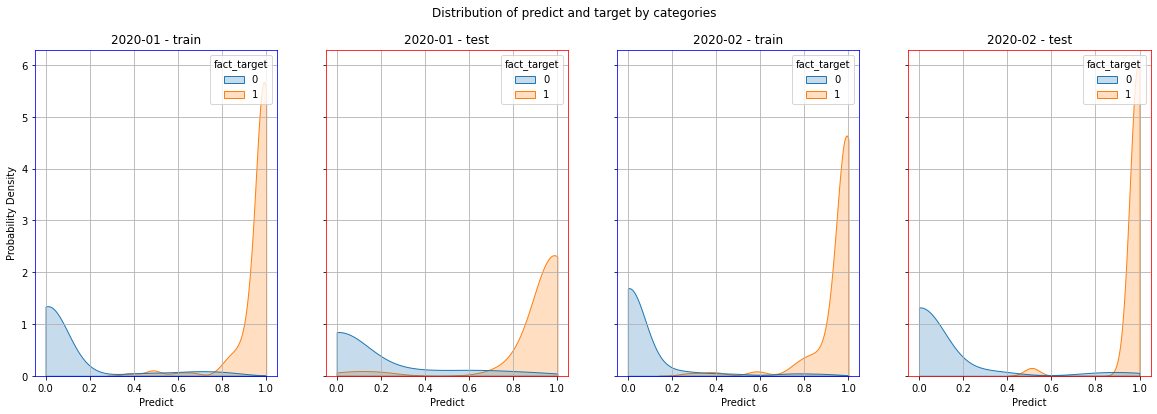

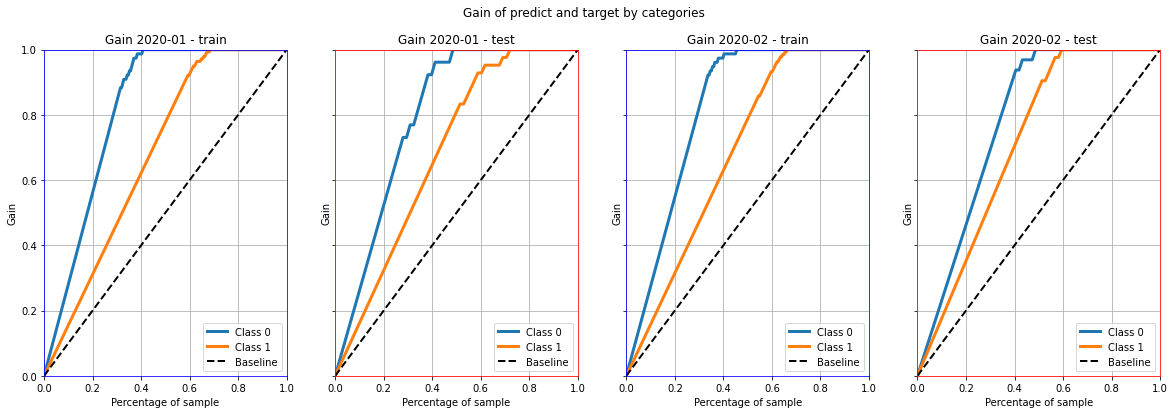

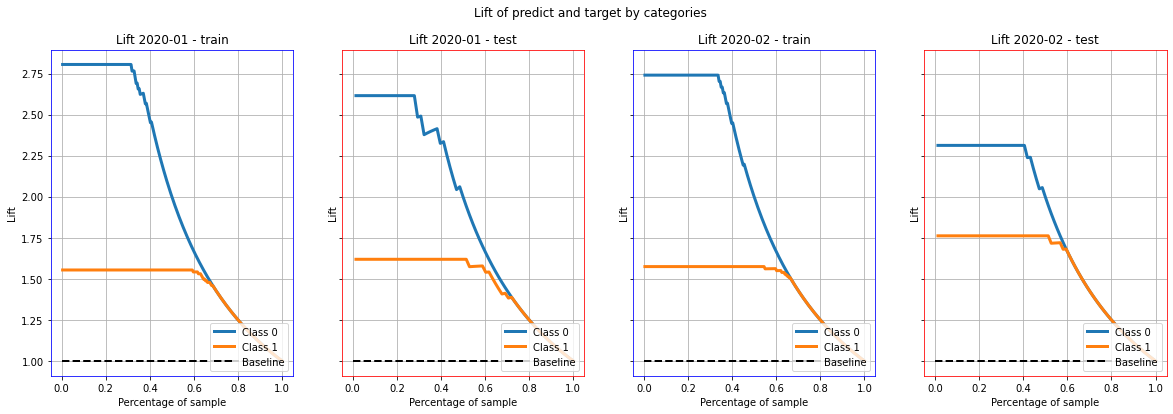

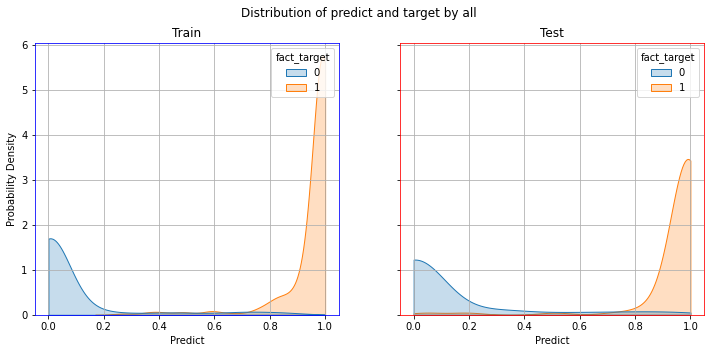

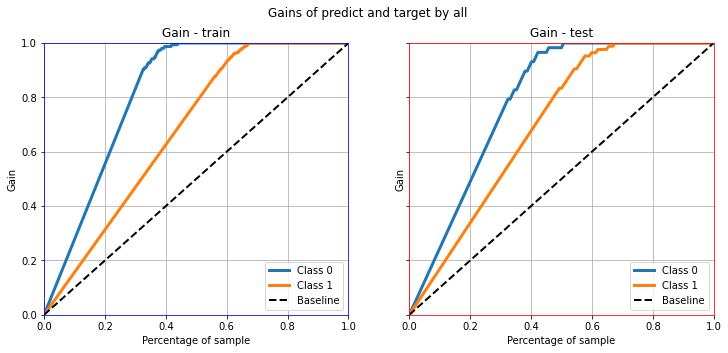

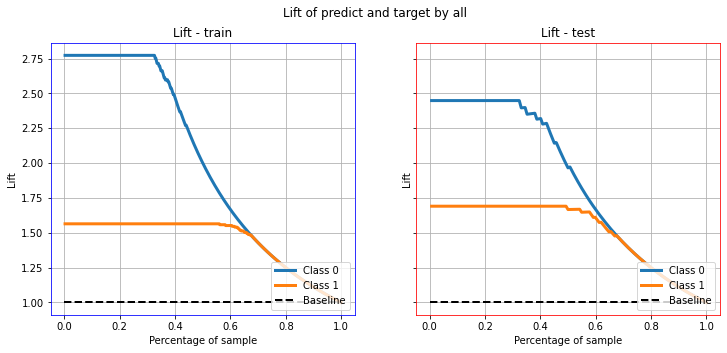

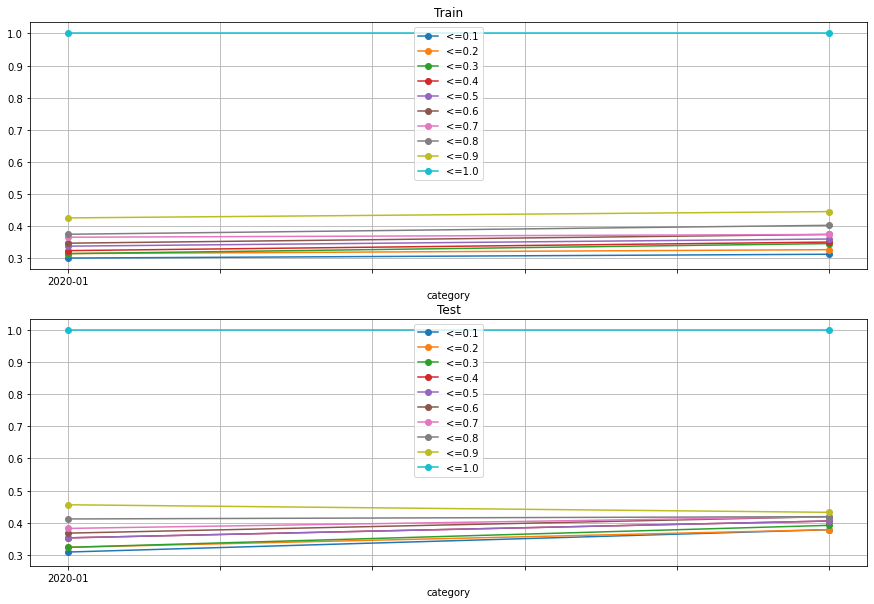

In [196]:
mq = model_quality(data)
report_metrics = mq.get_report(visualization=True)

## Результаты

In [144]:
# все доступные ключи
report_metrics.keys()

dict_keys(['general_report_table', 'cat_report_table', 'bin_report_table', 'viz_dist_cats', 'vis_dist_general', 'fig_gain_cats', 'fig_gain_general', 'fig_lift_cats', 'fig_lift_general', 'fig_bin_cats'])

In [145]:
report_metrics['general_report_table']

size     ratio  precision  recall        f1   roc_auc      gini  \
train  42521.0  0.202135   0.202135     1.0  0.336294  0.496066 -0.007868   
test    7479.0  0.207648   0.207648     1.0  0.343888  0.492412 -0.015176   

       fm_index  phi_coef  dor  cohens_d  cohen_kappa  brier_score   tn  \
train  0.449595       NaN  NaN  -2.80969          0.0     0.251214  0.0   
test   0.455684       NaN  NaN  -2.76255          0.0     0.256051  0.0   

            fp   fn      tp  threshold  
train  33926.0  0.0  8595.0        0.0  
test    5926.0  0.0  1553.0        0.0

In [146]:
report_metrics['cat_report_table']

category train_size test_size  target_train_ratio  target_test_ratio  \
0    2020-01-1       3627       637            0.208161           0.235479   
1    2020-02-2       3431       599            0.196736           0.210351   
2    2020-03-3       3529       609            0.191556           0.215107   
3    2020-04-4       3576       601            0.193233           0.201331   
4    2020-05-5       3539       672            0.204295           0.191964   
5    2020-06-6       3609       622            0.207537           0.215434   
6    2020-07-7       3617       639            0.213437           0.239437   
7    2020-08-8       3521       609            0.208179           0.205255   
8    2020-09-9       3544       637            0.205700           0.200942   
9   2020-10-10       3565       639            0.198317           0.192488   
10  2020-11-11       3446       630            0.198201           0.207937   
11  2020-12-12       3517       585            0.199602           0.174359   

    precision    recall        f1   roc_auc      gini  fm_index  phi_coef  \
0    0.235479  1.000000  0.381194  0.475989 -0.048022  0.485262       NaN   
1    0.210351  1.000000  0.347586  0.517727  0.035454  0.458640       NaN   
2    0.215107  1.000000  0.354054  0.470544 -0.058913  0.463796       NaN   
3    0.201331  1.000000  0.335180  0.512810  0.025620  0.448699       NaN   
4    0.191964  1.000000  0.322097  0.481441 -0.037118  0.438137       NaN   
5    0.215434  1.000000  0.354497  0.478399 -0.043201  0.464149       NaN   
6    0.239437  1.000000  0.386364  0.482282 -0.035437  0.489323       NaN   
7    0.205255  1.000000  0.340599  0.513802  0.027603  0.453050       NaN   
8    0.200942  1.000000  0.334641  0.496554 -0.006892  0.448265       NaN   
9    0.192488  1.000000  0.322835  0.482353 -0.035293  0.438735       NaN   
10   0.207937  1.000000  0.344284  0.482323 -0.035353  0.456001       NaN   
11   0.194712  0.794118  0.312741  0.526154  0.052308  0.393222   0.08416   

         dor  cohens_d  cohen_kappa  brier_score   tn   fp  fn   tp  threshold  
0        NaN -2.548202     0.000000     0.269470    0  487   0  150   0.000000  
1        NaN -2.740061     0.000000     0.248837    0  473   0  126   0.000000  
2        NaN -2.701427     0.000000     0.272897    0  478   0  131   0.000000  
3        NaN -2.816715     0.000000     0.243033    0  480   0  121   0.000000  
4        NaN -2.901483     0.000000     0.260051    0  543   0  129   0.000000  
5        NaN -2.698811     0.000000     0.254921    0  488   0  134   0.000000  
6        NaN -2.520504     0.000000     0.276788    0  486   0  153   0.000000  
7        NaN -2.782804     0.000000     0.234801    0  484   0  125   0.000000  
8        NaN -2.820129     0.000000     0.243006    0  509   0  128   0.000000  
9        NaN -2.896592     0.000000     0.258982    0  516   0  123   0.000000  
10       NaN -2.760131     0.000000     0.258497    0  499   0  131   0.000000  
11  1.704051 -1.284203     0.045406     0.249107  148  335  21   81   0.006634

In [147]:
report_metrics['bin_report_table']

bin_proba  is_test  count  mean_target  mean_predict
0   (-0.0001, 0.0999]        0  16940     0.204250      0.011620
1   (-0.0001, 0.0999]        1   2929     0.210994      0.011620
2       (0.0999, 0.2]        0   4224     0.198627      0.150391
3       (0.0999, 0.2]        1    731     0.225718      0.148071
4          (0.2, 0.3]        0   4329     0.207207      0.250000
5          (0.2, 0.3]        1    755     0.190728      0.249390
6          (0.3, 0.4]        0   3885     0.196911      0.348877
7          (0.3, 0.4]        1    683     0.215227      0.349854
8          (0.4, 0.5]        0   3399     0.198588      0.448975
9          (0.4, 0.5]        1    606     0.221122      0.451172
10         (0.5, 0.6]        0   2891     0.209616      0.547852
11         (0.5, 0.6]        1    557     0.184919      0.548828
12         (0.6, 0.7]        0   2273     0.198856      0.647949
13         (0.6, 0.7]        1    436     0.220183      0.646973
14         (0.7, 0.8]        0   1689     0.187093      0.748535
15         (0.7, 0.8]        1    280     0.196429      0.746094
16         (0.8, 0.9]        0   1180     0.204237      0.847168
17         (0.8, 0.9]        1    219     0.155251      0.849121
18         (0.9, 1.0]        0    736     0.199728      0.945801
19         (0.9, 1.0]        1    112     0.160714      0.944336

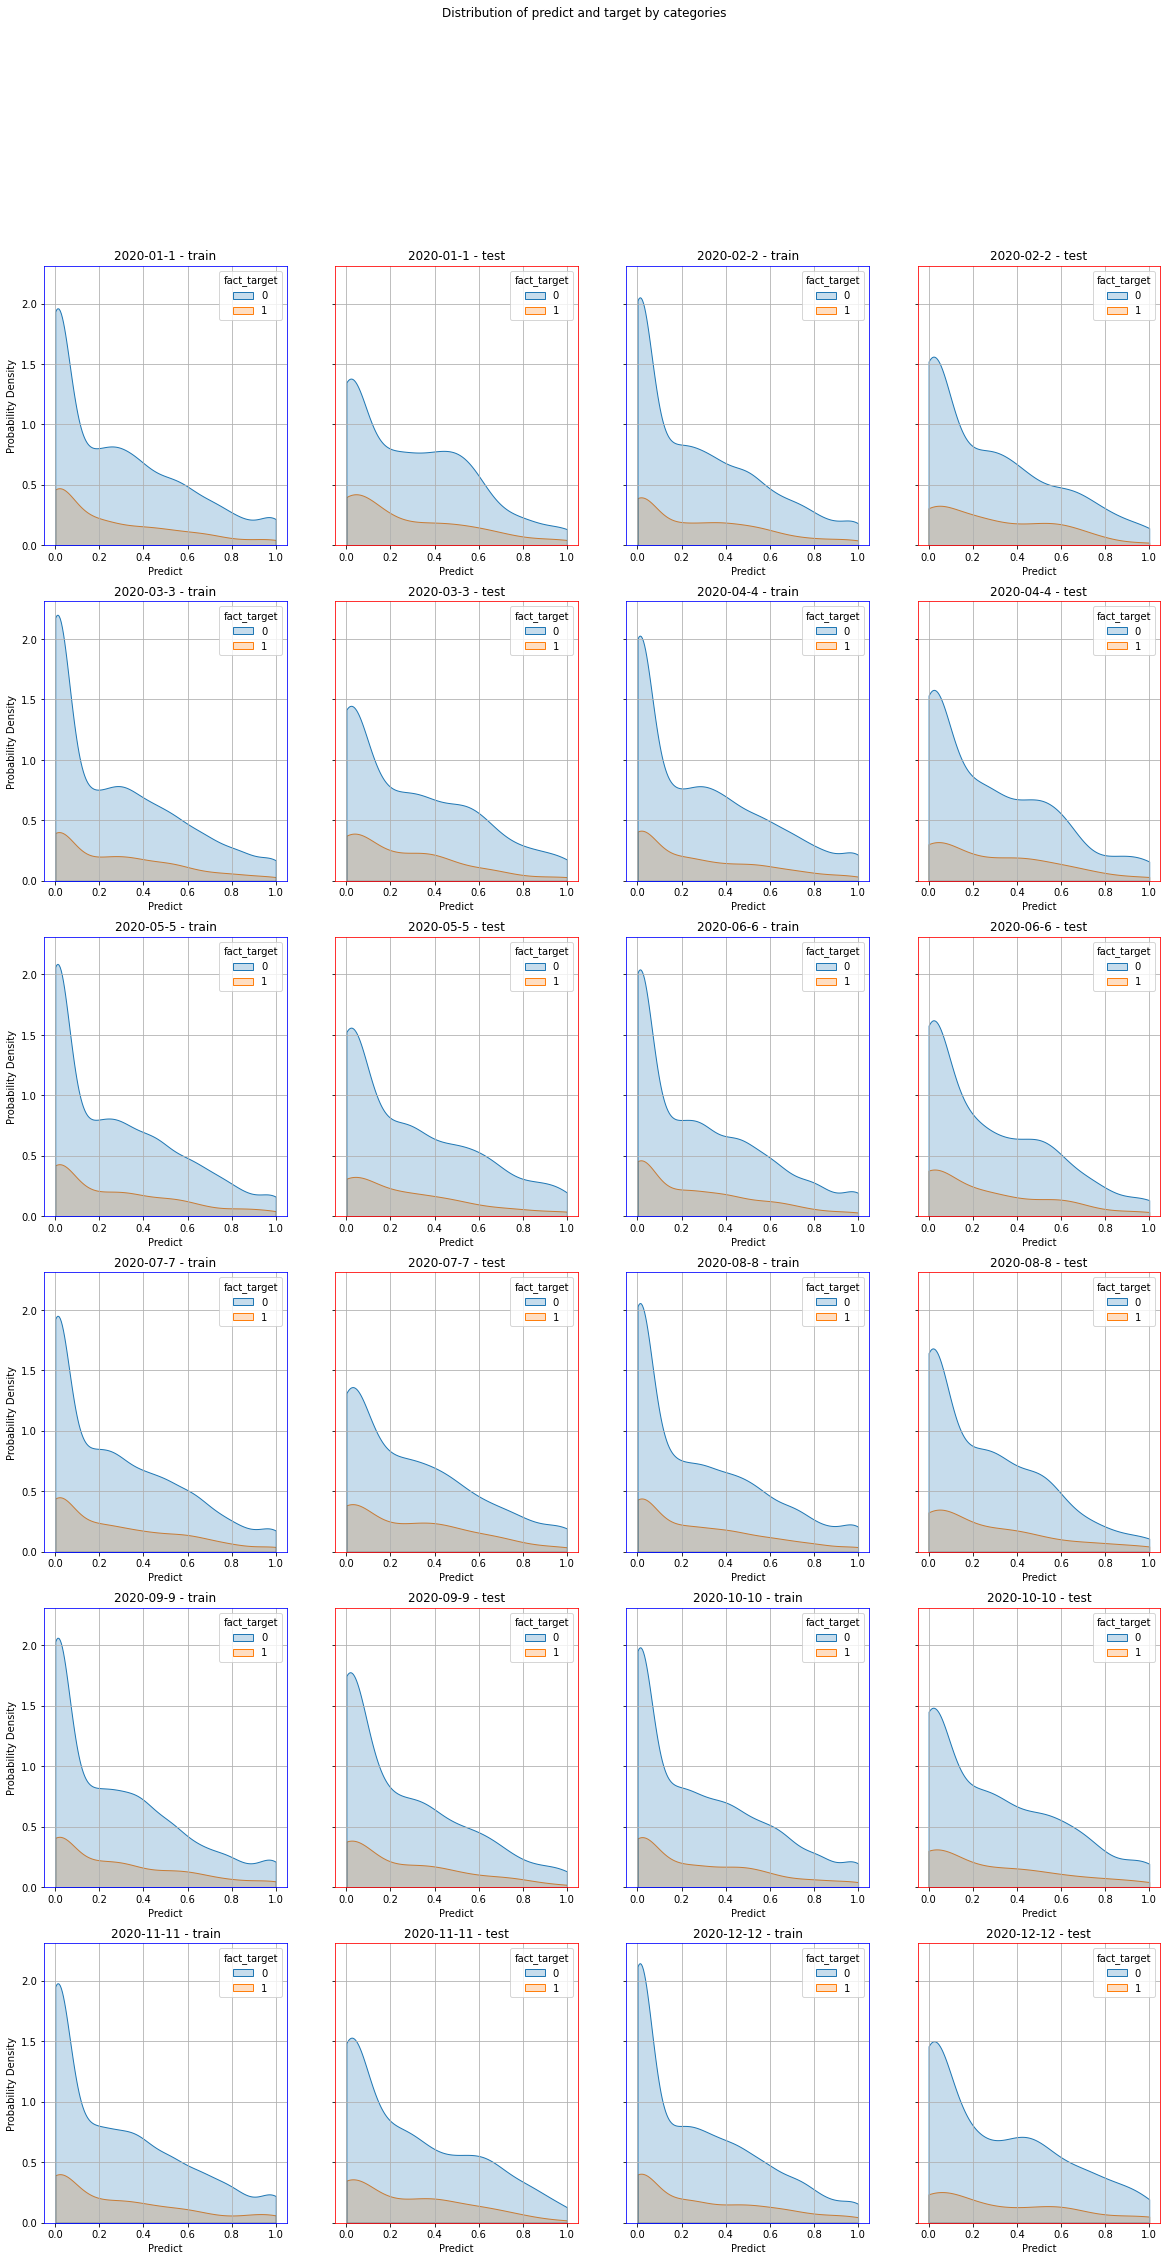

In [148]:
report_metrics['viz_dist_cats'] 

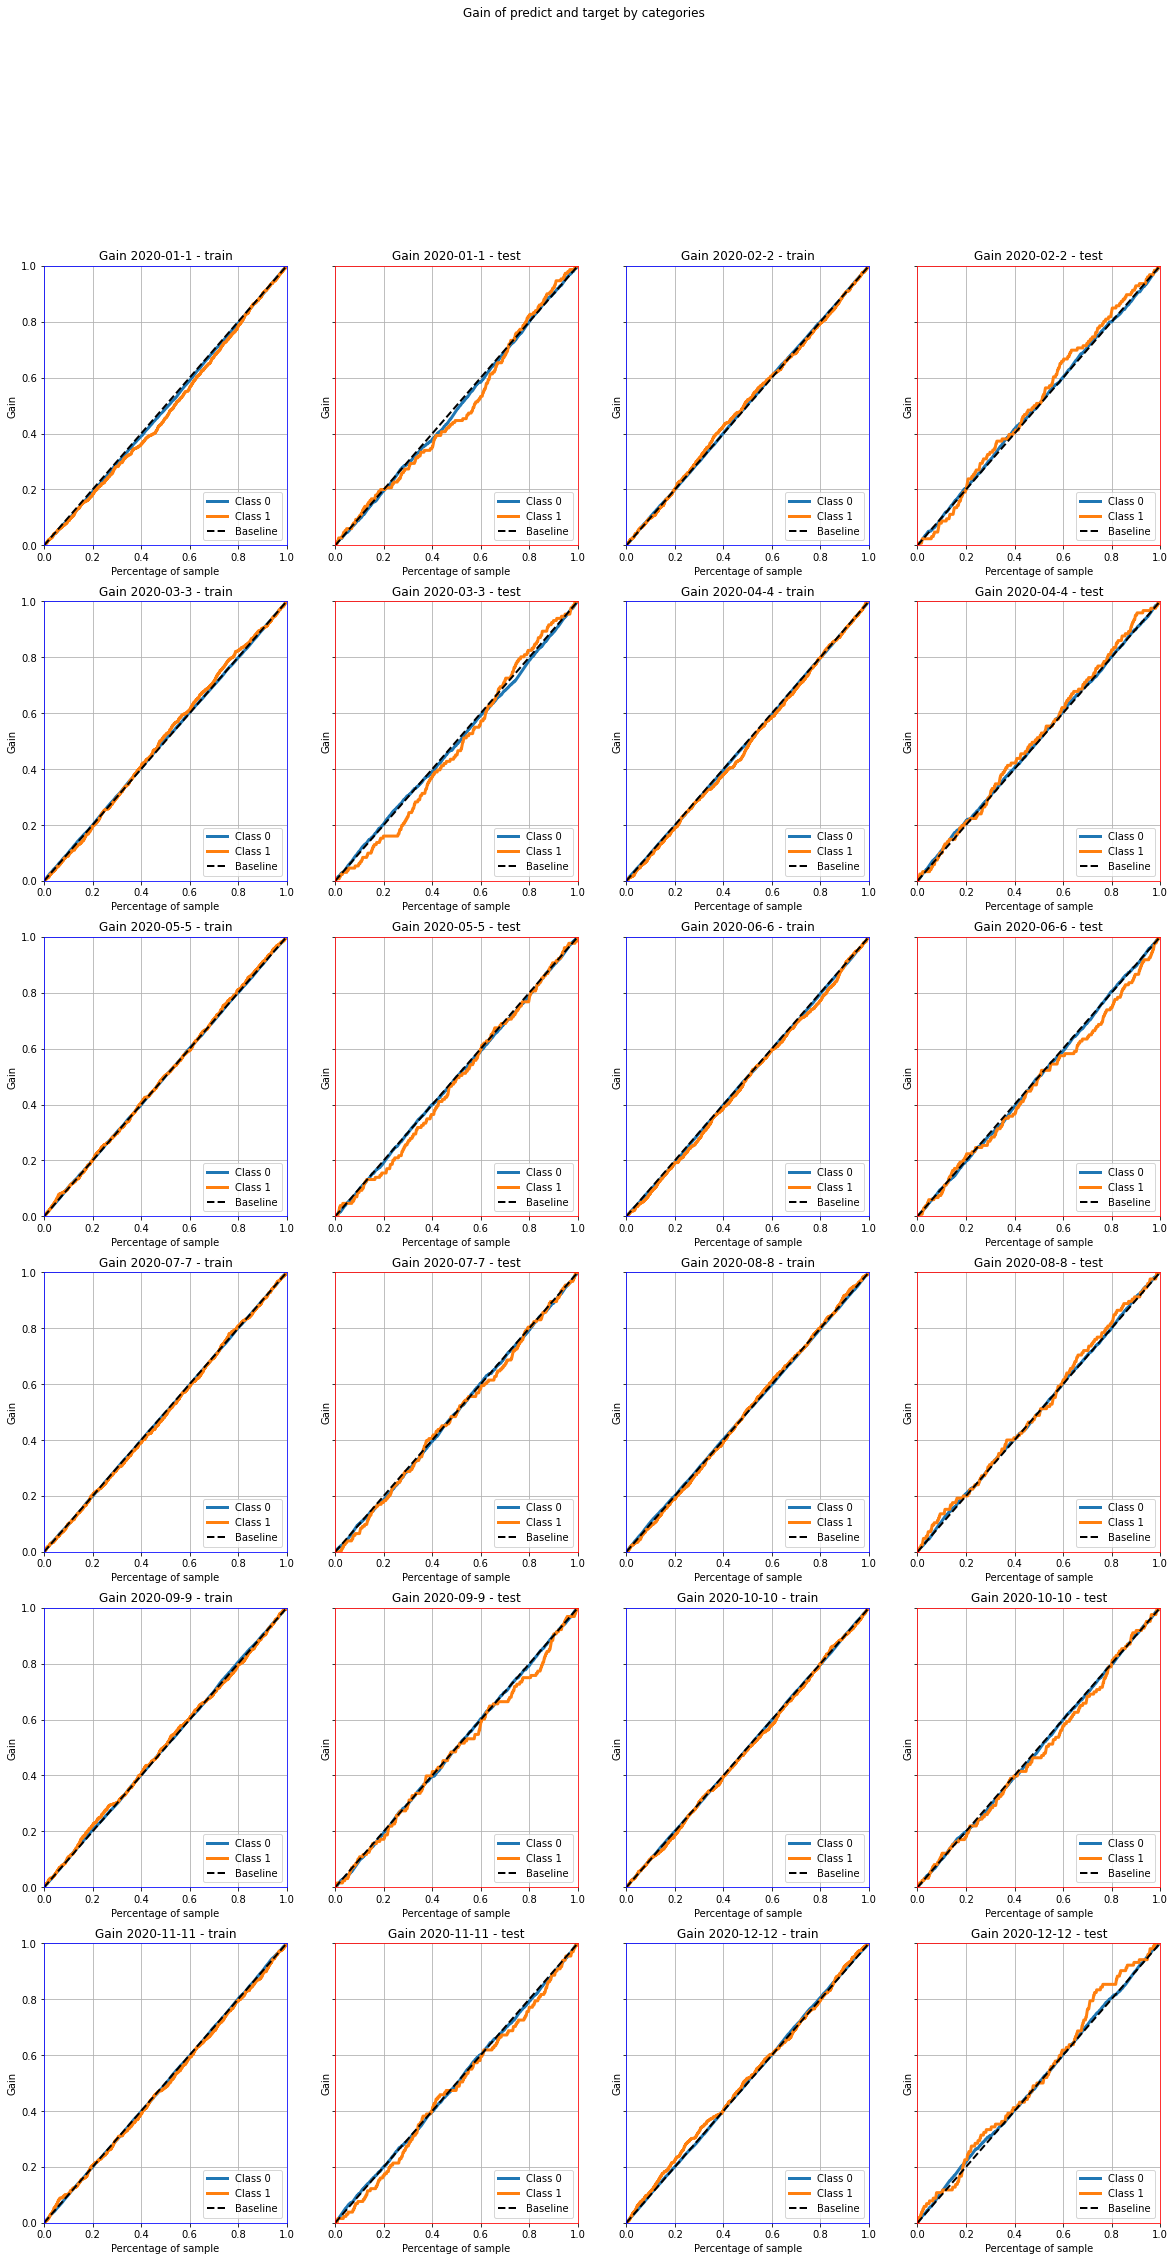

In [149]:
report_metrics['fig_gain_cats']

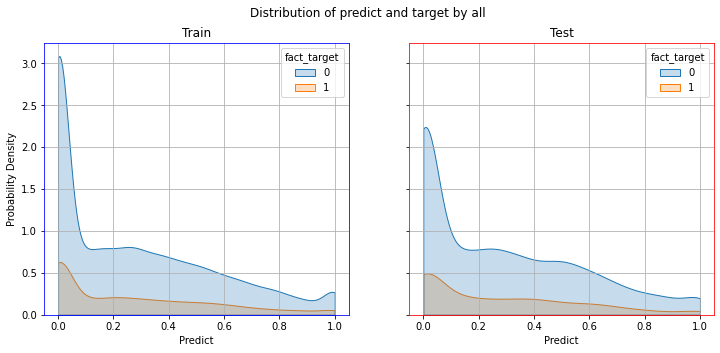

In [150]:
report_metrics['vis_dist_general']

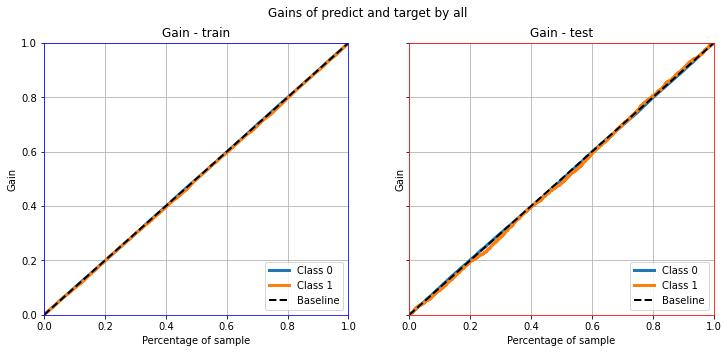

In [151]:
report_metrics['fig_gain_general']

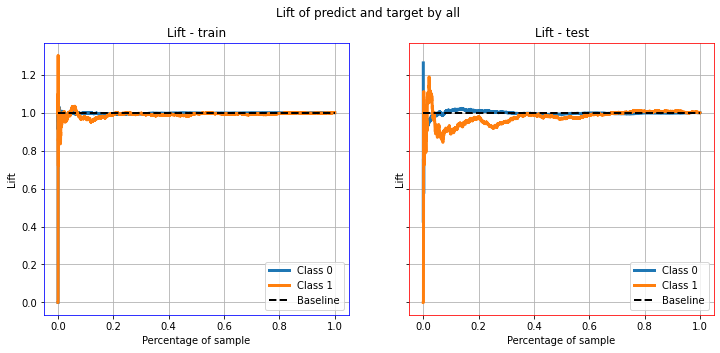

In [152]:
report_metrics['fig_lift_general']

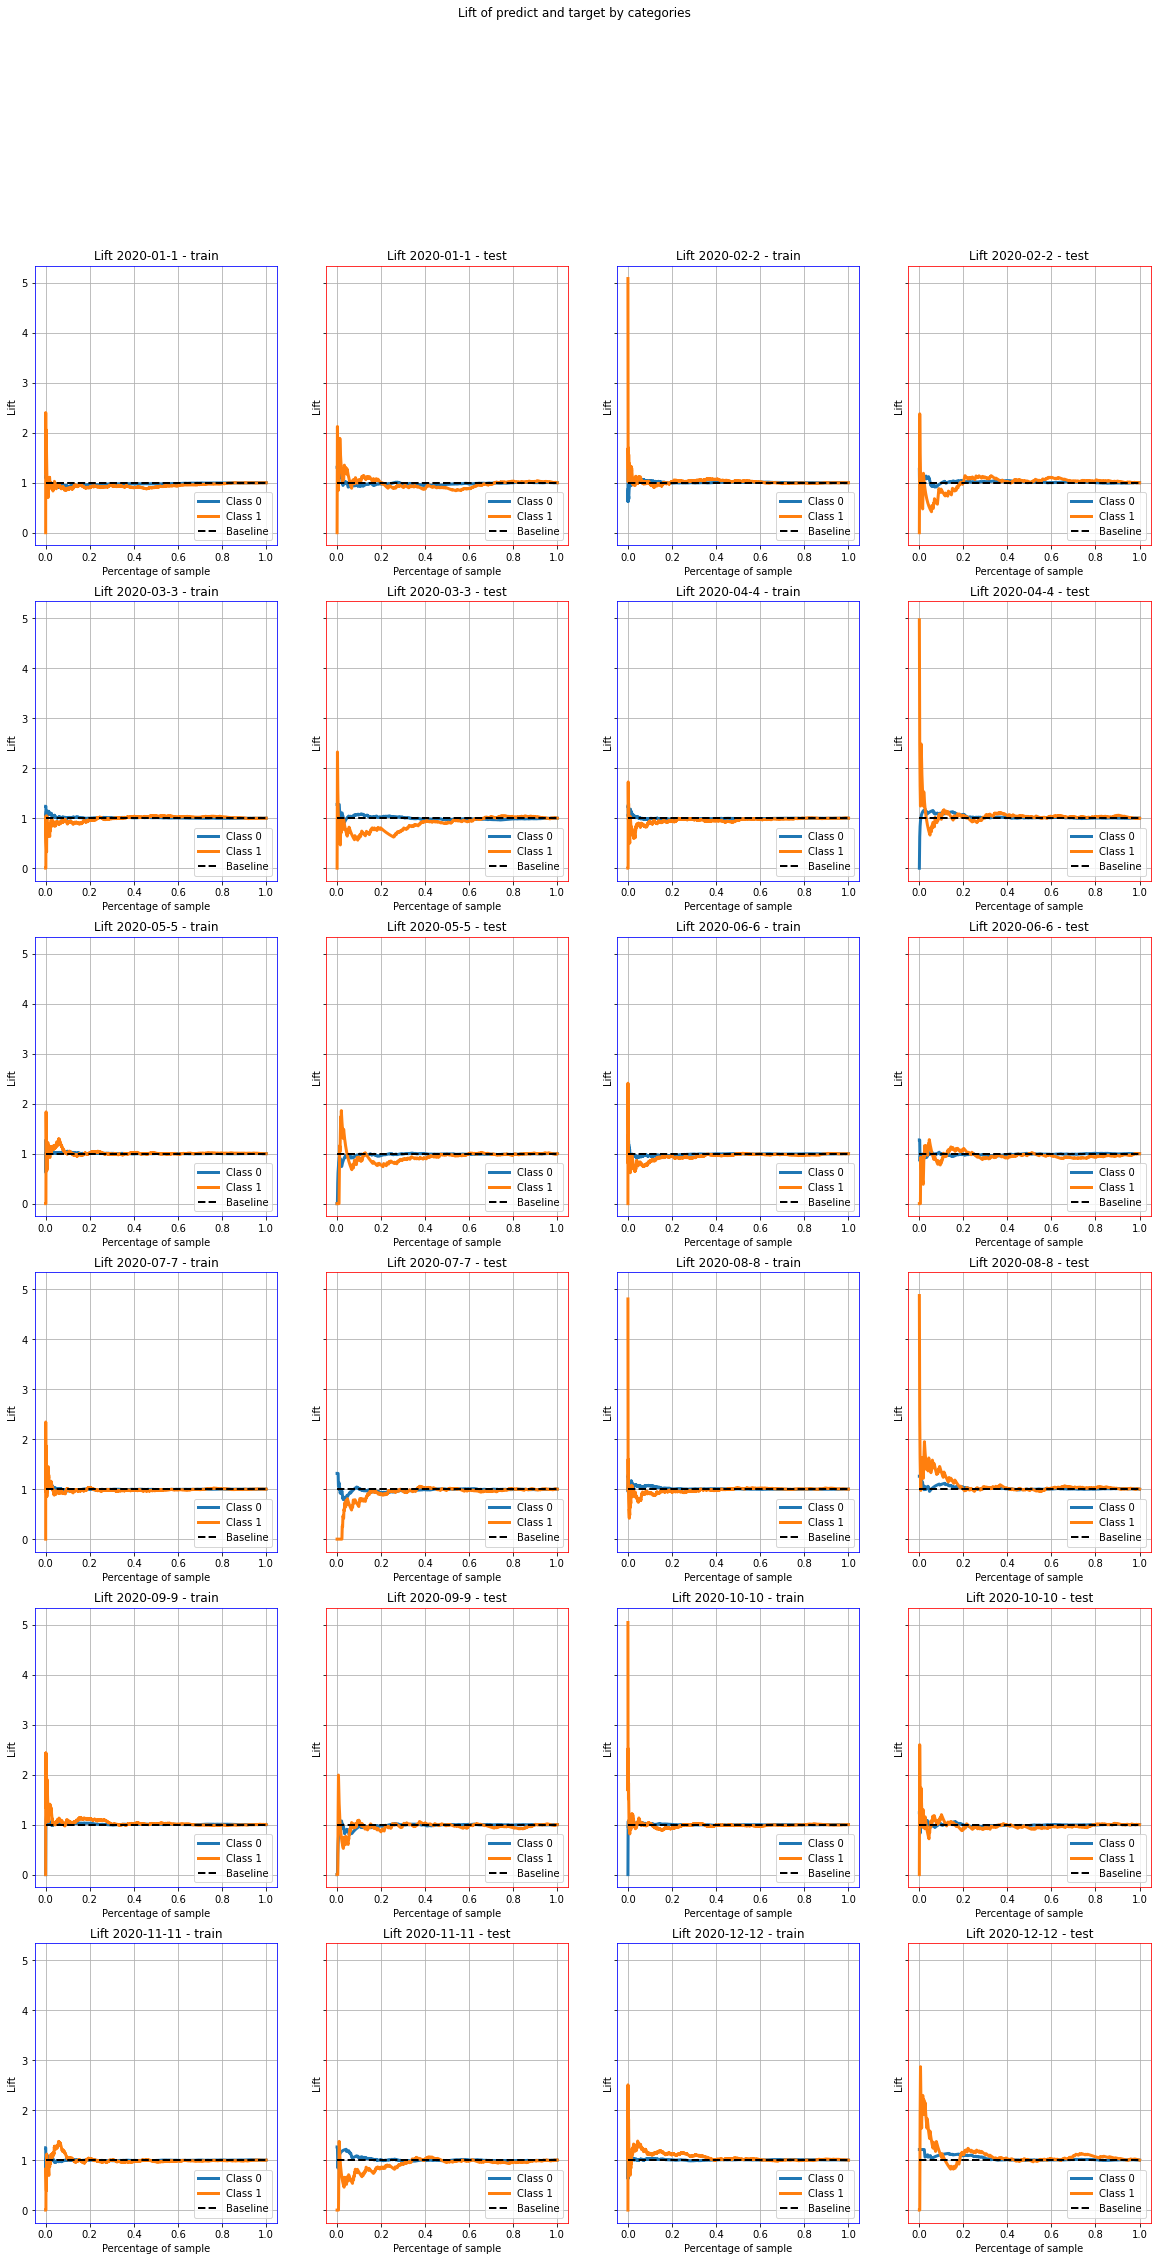

In [153]:
report_metrics['fig_lift_cats']

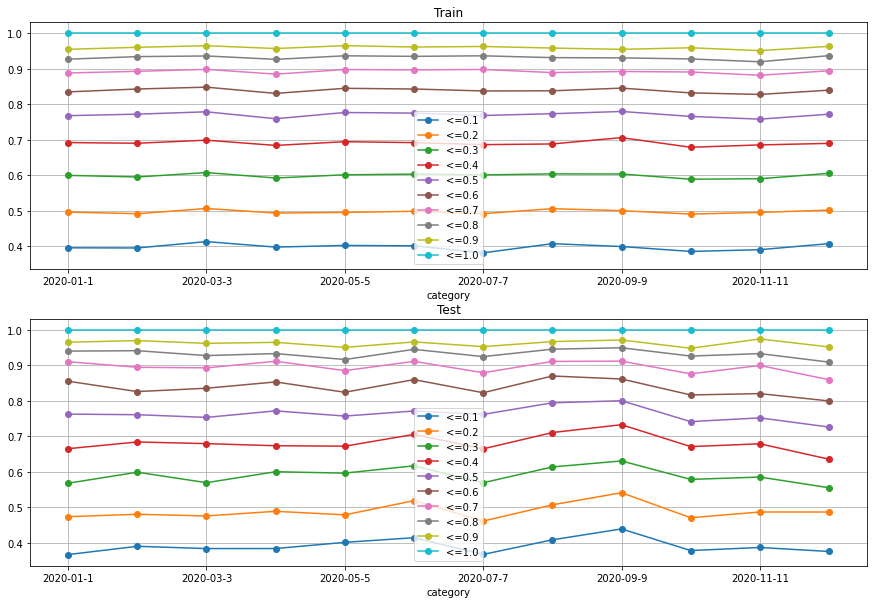

In [154]:
report_metrics['fig_bin_cats']

## Частная визуализация

Можно отрисовывать конкретные графики, указывая параметры (удобно в случае при большом кол-ве данных):

    general - общие графики
    unique_categories - список категорий по которым необходима отрисовка
    type_graphs - тип графиков

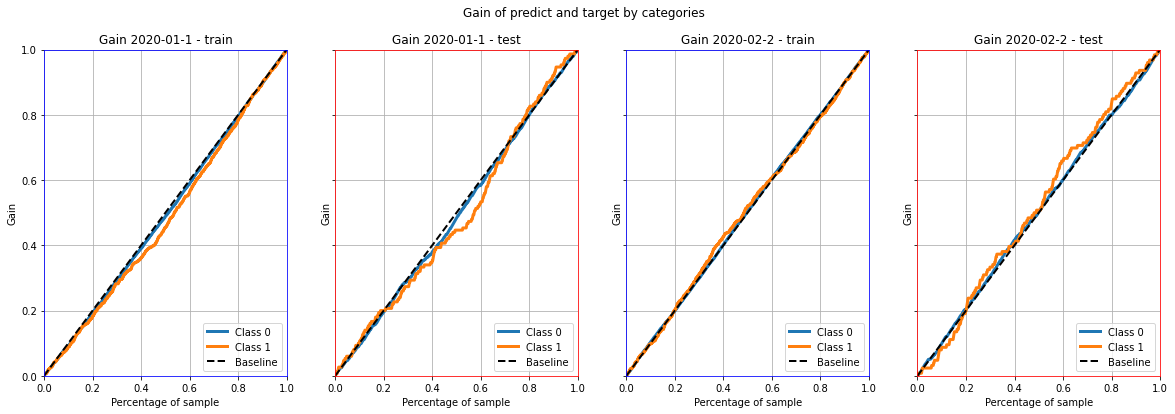

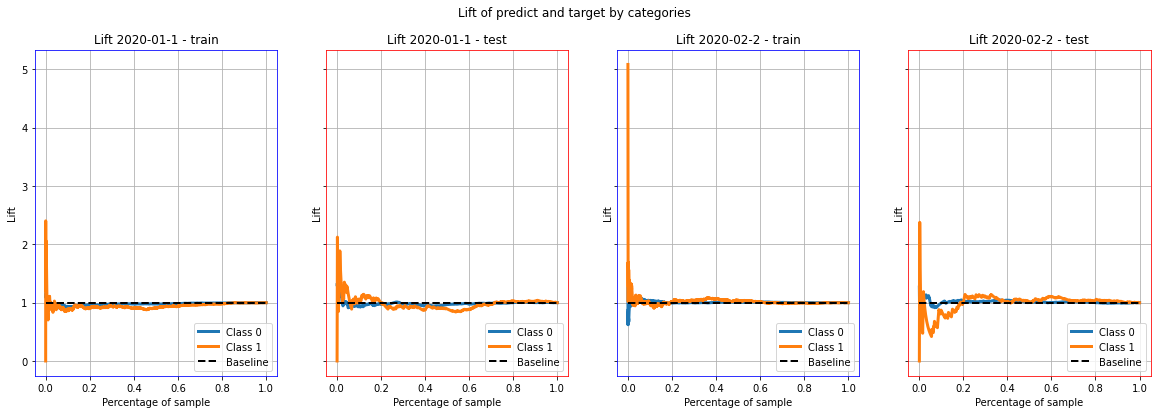

In [155]:
mq.visualize_target_predict(unique_categories=['2020-01-1','2020-02-2'], general=False, type_graphs=['gain', 'lift'])

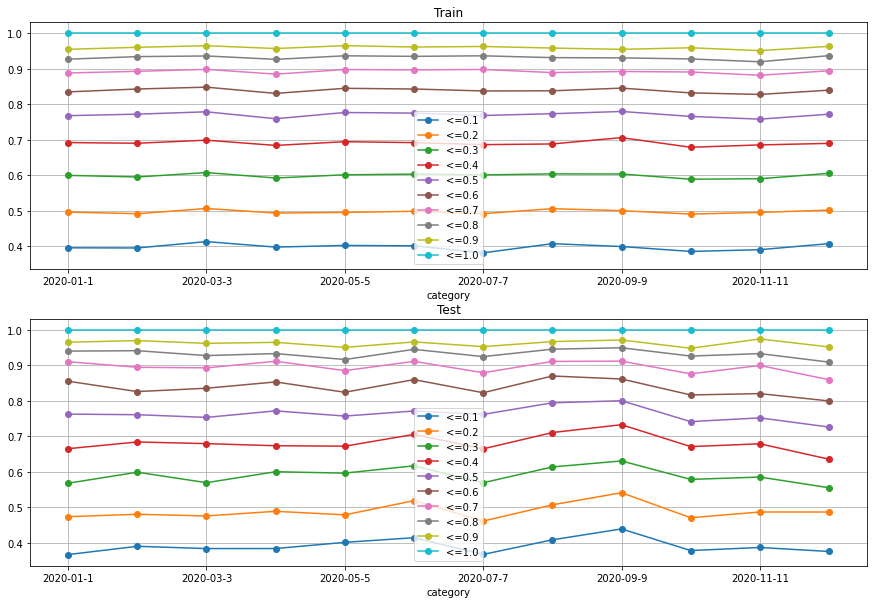

In [156]:
mq.get_ratio_probability_table()

In [188]:
a = mq.probability_table

In [191]:
a.index=a['category']

In [194]:
a.index.astype('')

Index(['2020-01', '2020-01', '2020-02', '2020-02'], dtype='object', name='category')